In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [2]:
# Load and clean data
df = pd.read_csv("D3.csv")
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(subset=['post', 'status'], inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
# Resample to balance classes (preserve counts printout)
max_count = df['status'].value_counts().max()
df_bal = pd.DataFrame()
for status, grp in df.groupby('status'):
    if len(grp) < max_count:
        grp_res = resample(grp, replace=True, n_samples=max_count, random_state=42)
    else:
        grp_res = grp
    df_bal = pd.concat([df_bal, grp_res])

df_bal.reset_index(drop=True, inplace=True)
print("After resampling:\n", df_bal['status'].value_counts())

df = df_bal

After resampling:
 status
EDAnonymous      6947
adhd             6947
alcoholism       6947
autism           6947
ptsd             6947
schizophrenia    6947
Name: count, dtype: int64


In [4]:
# Build dynamic label map and one-hot labels
target_names = sorted(df['status'].unique())
num_classes = len(target_names)
label_map = {label: idx for idx, label in enumerate(target_names)}
df['label'] = df['status'].map(label_map)

In [5]:
# Tokenize with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
enc = tokenizer(
    df['post'].astype(str).tolist(), padding='max_length', truncation=True,
    max_length=MAX_LEN, return_tensors='np'
)
input_ids = enc['input_ids']
attention_mask = enc['attention_mask']

In [6]:
# Prepare labels and tf.data dataset
labels = tf.keras.utils.to_categorical(df['label'], num_classes=num_classes)
dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': input_ids, 'attention_mask': attention_mask}, labels)
)


In [7]:
# Train/val/test split
BATCH = 32
dataset = dataset.shuffle(buffer_size=len(df), seed=42)
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_ds = dataset.take(n_train).batch(BATCH)
val_ds = dataset.skip(n_train).take(n_val).batch(BATCH)
test_ds = dataset.skip(n_train + n_val).batch(BATCH)

In [8]:
# Build model
def build_model():
    bert = TFBertModel.from_pretrained('bert-base-uncased')
    in_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    in_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    x = bert(in_ids, attention_mask=in_mask).pooler_output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=[in_ids, in_mask], outputs=out)

model = build_model()
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [9]:
# Compile model
optim = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
metrics = ['accuracy']
for cls, idx in label_map.items():
    metrics += [
        tf.keras.metrics.Precision(name=f"prec_{cls}", class_id=idx),
        tf.keras.metrics.Recall(name=f"rec_{cls}", class_id=idx)
    ]

model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=metrics
)

In [10]:
#  Train
epochs = 10
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10


1043/1043 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8531 - prec_EDAnonymous: 0.9394 - rec_EDAnonymous: 0.8447 - prec_adhd: 0.9120 - rec_adhd: 0.7954 - prec_alcoholism: 0.9682 - rec_alcoholism: 0.8841 - prec_autism: 0.9330 - rec_autism: 0.7898 - prec_ptsd: 0.9268 - rec_ptsd: 0.8036 - prec_schizophrenia: 0.9104 - rec_schizophrenia: 0.7588

C:\Users\TOH KAI KIAN\Documents\anaconda\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1043/1043 [==============================] - 9555s 9s/step - loss: 0.4288 - accuracy: 0.8531 - prec_EDAnonymous: 0.9394 - rec_EDAnonymous: 0.8447 - prec_adhd: 0.9120 - rec_adhd: 0.7954 - prec_alcoholism: 0.9682 - rec_alcoholism: 0.8841 - prec_autism: 0.9330 - rec_autism: 0.7898 - prec_ptsd: 0.9268 - rec_ptsd: 0.8036 - prec_schizophrenia: 0.9104 - rec_schizophrenia: 0.7588 - val_loss: 0.1530 - val_accuracy: 0.9571 - val_prec_EDAnonymous: 0.9967 - val_rec_EDAnonymous: 0.9068 - val_prec_adhd: 0.9420 - val_rec_adhd: 0.9762 - val_prec_alcoholism: 0.9829 - val_rec_alcoholism: 0.9773 - val_prec_autism: 0.9812 - val_rec_autism: 0.9206 - val_prec_ptsd: 0.9504 - val_rec_ptsd: 0.9476 - val_prec_schizophrenia: 0.9710 - val_rec_schizophrenia: 0.9358
Epoch 2/10
1043/1043 [==============================] - 9441s 9s/step - loss: 0.1475 - accuracy: 0.9574 - prec_EDAnonymous: 0.9761 - rec_EDAnonymous: 0.9530 - prec_adhd: 0.9601 - rec_adhd: 0.9528 - prec_alcoholism: 0.9880 - rec_alcoholism: 0.9752 - prec

In [11]:
# Evaluate predictions
y_true, y_score = [], []
for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch)
    y_score.append(probs)
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
y_score = np.vstack(y_score)

y_pred = np.argmax(y_score, axis=1)

1/1 [==============================] - 3s 3s/step


In [12]:
# Classification report
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

               precision    recall  f1-score   support

  EDAnonymous     1.0000    0.9915    0.9957       704
         adhd     0.9986    0.9943    0.9964       699
   alcoholism     0.9971    0.9985    0.9978       685
       autism     1.0000    0.9984    0.9992       633
         ptsd     0.9918    1.0000    0.9959       730
schizophrenia     0.9945    0.9986    0.9965       718

     accuracy                         0.9969      4169
    macro avg     0.9970    0.9969    0.9969      4169
 weighted avg     0.9969    0.9969    0.9969      4169



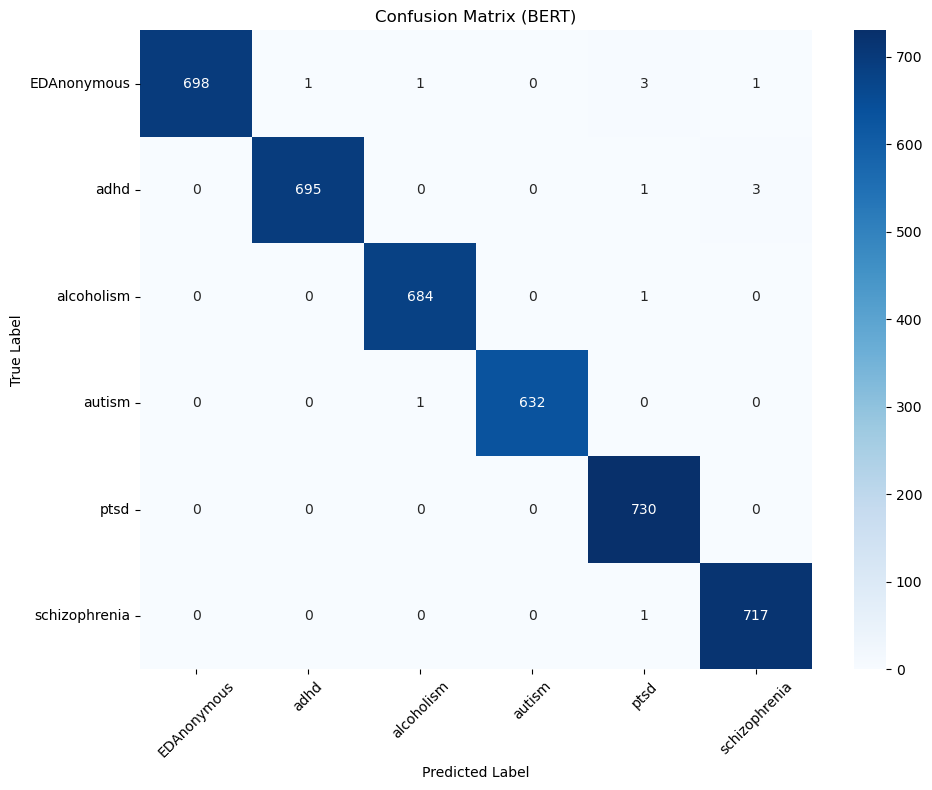

In [20]:
# Confusion matrix 
import seaborn as sns
plt.figure(figsize=(10, 8))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix (BERT)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

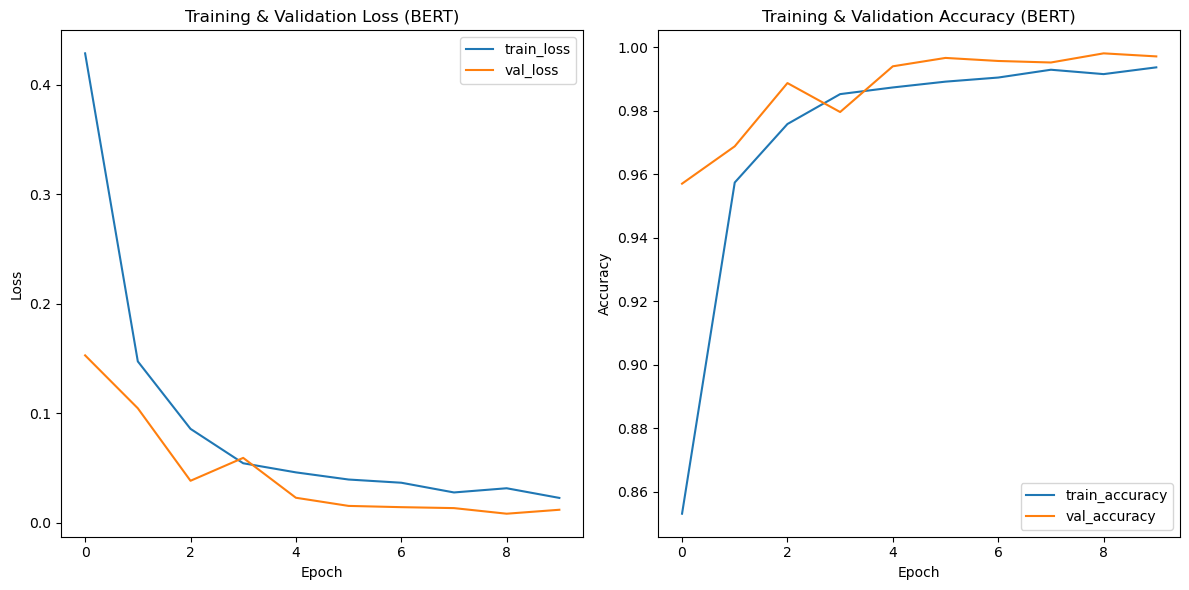

In [21]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

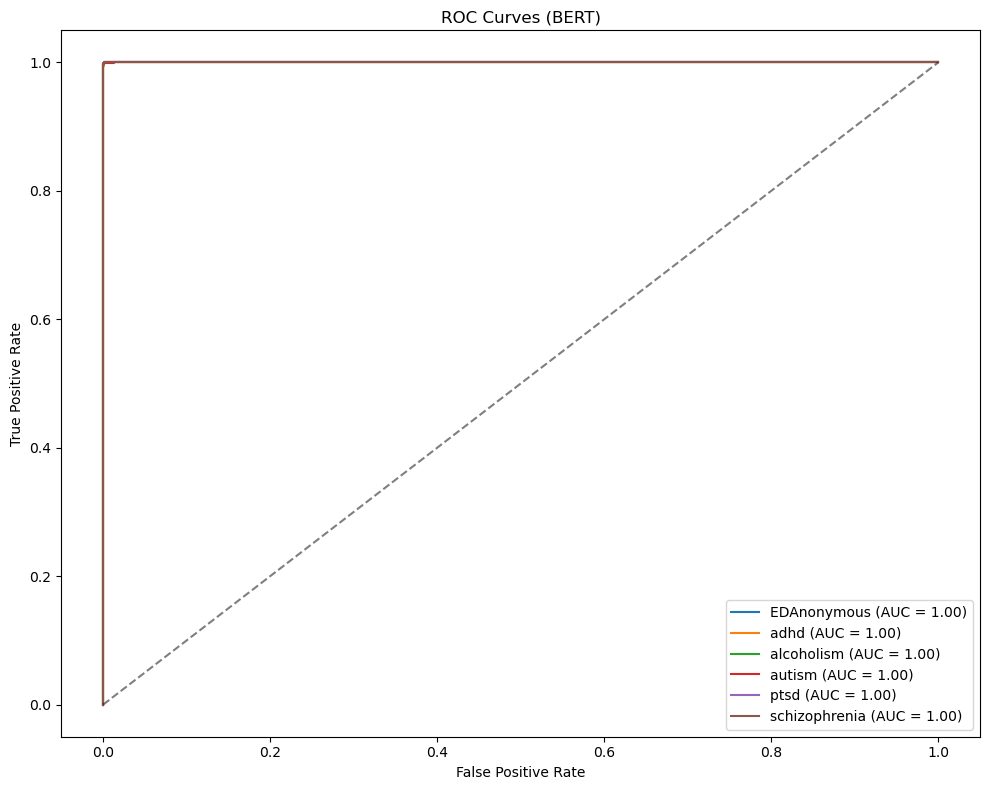

In [22]:
# ROC Curves
from tensorflow.keras.utils import to_categorical
y_true_bin = to_categorical(y_true, num_classes=num_classes)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('ROC Curves (BERT)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

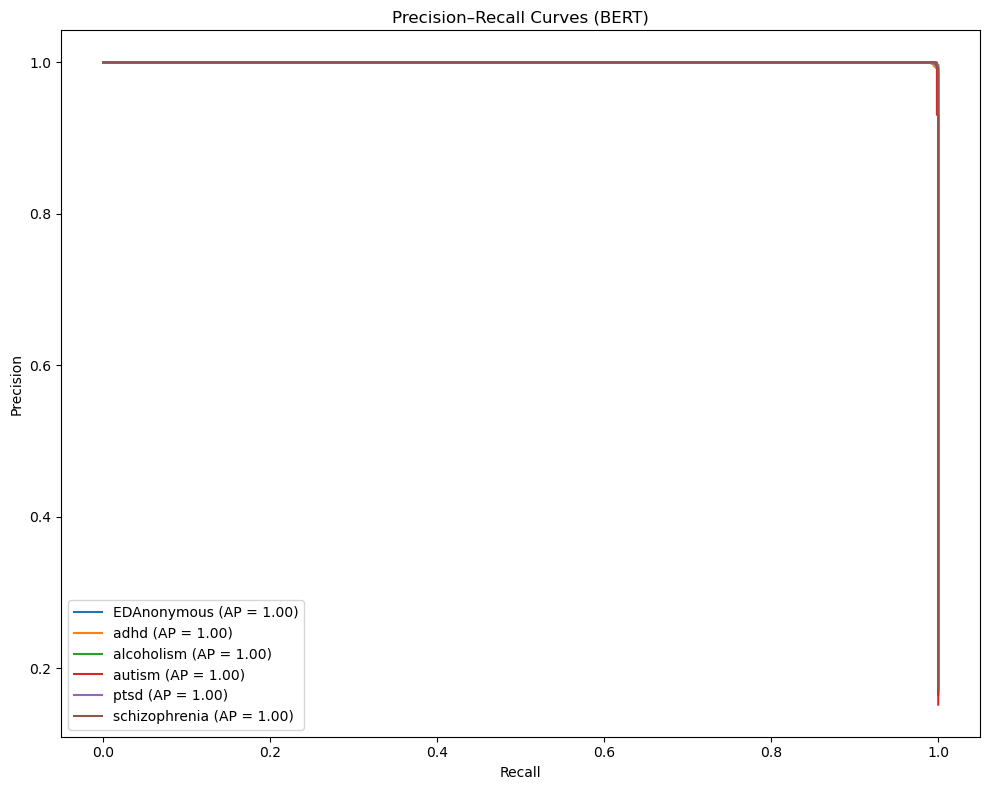

In [23]:
# Precision–Recall Curves 
plt.figure(figsize=(10, 8))
for i, cls in enumerate(target_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP = {ap:.2f})")
plt.title('Precision–Recall Curves (BERT)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()